# Parallel Processing Basics
This is second-level notebook on MsPASS fundamentals.  It can only be run 
after completion of the "getting_started.ipynb" while running the container rooted at the same working directory where you ran that first tutorial.  You will need that to get access to the MongoDB database created in that tutorial.

The learning objective of this tutorial is these elements of developing a parallel workflow in MsPASS:
1.  Guidance on how to develop the python code that defines your workflow to run in parallel.   That development normally should be done on a small subset of the data as a "serial job" before transforming the task to a parallel job.
2.  How to translate your serial prototype into a parallel job.
3.  MsPASS supports two different "schedulers" for handling parallel processing:  (1) dask, and (2) spark (technically pyspark).  This tutorial shows the same simple workflow with both dialects.

First, usual connection to the database.

In [1]:
from mspasspy.db.database import Database
import mspasspy.client as msc
dbclient=msc.Client()
db = dbclient.get_database('getting_started')

Then doing a series of imports needed to support the workflow.  Note common practice is that during development of a workflow in a notebook it is a good idea to keep most imports at the top like this, add to the code as needed, and after each change push the run button.

In [23]:
from mspasspy.io.distributed import read_distributed_data,write_distributed_data
from mspasspy.algorithms.window import WindowData,scale
from mspasspy.algorithms.basic import ator
from mspasspy.ccore.algorithms.basic import TimeWindow
from mspasspy.ccore.utility import ErrorSeverity
from mspasspy.db.normalize import ObjectIdMatcher
from obspy import UTCDateTime
import time

## Serial Prototype
A key concept to understand about the normal model for parallel processing with MsPASS is that most workflows of interest can be prototyped as a top-level loop over data.   i.e. in pseudocode the processing boils down to `foreach datum do something` where the `something` is a chain of processing algorithms.   That type of data handling is commonly called a "pipeline" and is universally recognized as "embarrassingly parallel".   That means simply that parallel processing can nearly always perform well and scale close to optimal values based on __[Amdahl's Law](https://en.wikipedia.org/wiki/Amdahl%27s_law)__.

Because most processing workflows can be reduced to a pipeline, we have found that it is always wise to prototype your workflow code with a "serial" version that defines a loop over data.   In hopes of making that less abstract here is the serial version of the processing sequence we will run repeatedly in this tutorial.   More on what this box contains is in a text box after the code.  

In [19]:
def shift_by_Ptime(d):
    if d.live:
        if d.is_defined('Ptime'):
            tshift = d['Ptime']
            d = ator(d,tshift)
        else:
            d.kill()
            d.elog.log_error("shift_by_Ptime",
                             "Required key Ptime is was not defined",
                             ErrorSeverity.Invalid)
    return d

In [20]:
stime = -20.0
etime = 400.0
station_normalizer = ObjectIdMatcher(db,
                                    collection='channel',
                                    attributes_to_load=[
                                            '_id',
                                            'lat',
                                            'lon',
                                            'elev',
                                            'hang',
                                            'vang',
                                           ]
                                          ) 
source_normalizer = ObjectIdMatcher(db,
                                    collection='source',
                                    attributes_to_load=[
                                            '_id',
                                            'lat',
                                            'lon',
                                            'depth',
                                            'time',
                                           ]
                                          )
t0 = time.time()
output_data_tag = 'serial_prototype'
# note call to limit method - see box below
cursor = db.wf_TimeSeries.find({'data_tag' : 'preprocessed'}).limit(5)
for doc in cursor:
    d = db.read_data(doc,
                     collection='wf_TimeSeries',
                     normalize=[station_normalizer,source_normalizer])
    d = shift_by_Ptime(d)
    d = WindowData(d,stime,etime)
    save_output = db.save_data(d,data_tag=output_data_tag)
    print(save_output)
t=time.time()
print("Processing time=",t-t0)
print("Time per datum=",(t-t0)/5)

{'is_live': True, '_id': ObjectId('65c2178cf2e9f5c93938da7c')}
{'is_live': True, '_id': ObjectId('65c2178cf2e9f5c93938da7f')}
{'is_live': True, '_id': ObjectId('65c2178cf2e9f5c93938da82')}
{'is_live': True, '_id': ObjectId('65c2178cf2e9f5c93938da85')}
{'is_live': True, '_id': ObjectId('65c2178cf2e9f5c93938da88')}
Processing time= 0.30959534645080566
Time per datum= 0.06191906929016113


Things to note about this code that defines this "workflow" are:
1.  The biggest point here is the for loop.  It defines an iteration over data using a MongoDB `Cursor`.   In MsPASS cursor-driven loops are a common construct.   A `Cursor` acts like a python list so we can us it in python programiong constructs like `for doc in cursor:`.   In reality, however, it is something very different as a Cursor interacts with MongoDB to essentially assure as the loop progresses MongoDB will feed it "documents", which it stores in the `doc` symbol, to be handled sequentially.   The loop terminates when the result of the query is exhausted.
2.  The loop is driven by "documents" (defined with the symbol here `doc`) retrieved from the "wf_TimeSeries" collection.   (Note "wf_TimeSeries" is not actually required in the above context as it is the default for the collection argument.  It is included to emphasize the point that the collection definition is critical for the reading to succeed.)
3.  The first process is a "call to the read_data method of Database`.  For this style of data loop `read_data` is driven by an input "document".  A lot is hidden behind that one line to construct a complete `TimeSeries` object.  As noted earlier our aim was to abstract the read and write operators as much as possible to hide the grundy details of what it takes to make that work.   As you learn MsPASS you may want or need read about such details in the User's Manual.
4.  We used the `normalize` argument in `read_data` to load source and receiver metadata with each datum.   We use a different scheme than the that in "getting_started" based on id matching.  Above the loop we create the two "matchers" assigned the symbols `station_matcher` and `source_matcher`.   The approach here works ONLY because getting started set two key attributes stored with each `doc` processed in this loop:  (1) `channel_id` is the cross-referencing id for "channel" and (2) `source_id` is the cross-referencing id for source.  "Normalization" is an important side topic addressed at length in the User's Manual and other tutorials. It is secondary here, and is not, in fact, actually even needed in this workflow.  We included it just for its instructional value.
5.  We apply two processing functions:  (1) `shift_by_Ptime` is defined in the box immediatly above.  It changes from UTC to "relative" time with 0 defined by the value of the "Ptime" attribute retrieved from each datum by the function.  (2) `WindowData` cuts the larger waveform segment down to a smaller window from 20 s before (minus sign) Ptime to 400 s after Ptime.  Note the values of `stime` and `etime` are "relative time", which in this case uses the value of "Ptime" as 0.
6.  The last step the processing loop is to save the data to the database.   An important details is that the `data_tag` value is almost alway desirable on a save.  Normal practice is to stuff all results into a single "wf collection" like "wf_TimeSeries".   The only way you can examine a specific version of results is to use the "data_tag" field to look at the results.

Finally, let's retrieve what we just saved and plot it to see that the processing did what we expected it to.

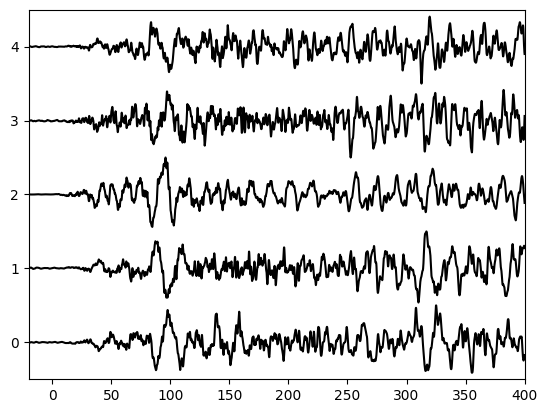

In [25]:
from mspasspy.graphics import SeismicPlotter
plotter = SeismicPlotter()
plotter.change_style('wt')  
cursor=db.wf_TimeSeries.find({'data_tag' : output_data_tag}) 
ensemble=db.read_data(cursor,collection='wf_TimeSeries')
ensemble = scale(ensemble,level=0.5)
plotter.plot(ensemble)

### Parallel Workflow with dask distributed
As noted at the top there are two "schedulers" that can be used in MsPASS.  The default is __[dask](https://www.dask.org/)__.  There are currently two different "schedulers" available in dask.  We recommend the newer one called __[dask distributed]()__.   We enable that with this incantation:


In [26]:
from dask.distributed import LocalCluster
cluster = LocalCluster()
client = cluster.get_client()

/opt/conda/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34139 instead
  warnings.warn(


With dask you use variants for this setup when your transfer your workflow for a "local" system to a cluster.  The way dask recommends to do that is (currently at least - these pages are volatile) described in the the section titled "How to Deploy Dask" __[found here](https://docs.dask.org/en/stable/)__

A feature we will explore in this tutorial is their __[diagnostic monitor](https://distributed.dask.org/en/stable/diagnosing-performance.html)__.  It is very useful for monitoring performance of a long-running job and to verify your cluster setup is configured correctly.  The status page diagnostics page is now available to you an can be accessed via port 8787.   It is because of that requirement that we asked you to start the container with the `-p 8787:8787` incantation.   Without that port mapping you would not be able to connect to the diagnostics page.   We note that in our experience using the hyperlink above will no always work either.   You instead will probably need to use the link via the default localhost of `127.0.0.1:8787/status` or using some specific hostname on a cluster.  You might be able to click on [this link](http://127.0.0.1:8787/status).   If that doesn't work resort to a cut and paste of the above url. 

Now that we have dask diagnostics running let's run a variation of the above workflow that will allow do the same processing parallel.   We will discuss the programming details below, but for now we suggest you run this code and play with the diagnostics monitor while it runs.  A last point before you release the machine is IF you choose to run the box below more than once CHANGE THE VALUE OF `output_data_tag`.  If you don't you won't be able to untangle the multiple runs. 

In [16]:
stime = -20.0
etime = 400.0
station_normalizer = ObjectIdMatcher(db,
                                    collection='channel',
                                    attributes_to_load=[
                                            '_id',
                                            'lat',
                                            'lon',
                                            'elev',
                                            'hang',
                                            'vang',
                                           ]
                                          ) 
source_normalizer = ObjectIdMatcher(db,
                                    collection='source',
                                    attributes_to_load=[
                                            '_id',
                                            'lat',
                                            'lon',
                                            'depth',
                                            'time',
                                           ]
                                          )
output_data_tag='dask_parallel_example"
t0 = time.time()
dataset = read_distributed_data(db,
                collection='wf_TimeSeries',
                normalize=[station_normalizer,source_normalizer],
                data_tag='preprocessed',
            )
dataset = dataset.map(shift_by_Ptime)
dataset = dataset.map(WindowData,stime,etime)
write_result = write_distributed_data(dataset,
                        db,
                        data_tag=output_data_tag,
                    )
t=time.time()
print("Total processing time=",t-t0)

Total processing time= 99.06604838371277


Compare the above with the earlier serial job.  The for loop command and read_data line are replaced by the following line:
```
bg = read_distributed_data(db,cursor,normalize=['source'])
```
The `read_distributed_data` function creates a container called a dask "bag".  A convenient way to view a bag is list of things that doesn't need to fit in memory.   The "things", in our case, are mspass TimeSeries objects.   The `read_distributed_data` line is followed by a series of lines that in python jargon apply the "map method" of the "bag" object/container. The concept of a "map" operator is one of the two keywords in the modern concept of the "map-reduce" model of big data science.  You can find many web pages and turorials discussing map-reduce in general and map-reduce for dask in particular.   For now, we emphasize that arg0 of the map method is a function name.  Each call to map applies a named function to data that it assumes emits another datum that is always the same type.   All the processing functions in the loop above use that model.  For example, the `resample` function takes an input TimeSeries of any sample rate and returns a resampled representation of that datum at 20 sps.  

With that background, note the workflow runs a sequence of algorithms through the map method driven by the same function names as above in the same order. For example, consider this line in the serial job that runs the normalize function we used earlier:
```
d = normalize(d,station_matcher)
```
The comparable operator above is this:
```
bg = bg.map(normalize,station_matcher)
```
The key point we want to make here is that it is straightforward to convert any loop like the serial job to a parallel version using dask.  There are three deviation:
1.  The call to the ator function required us to use a python `lambda` function.  That is often a useful trick to handle variable arguments padded through header values.   If you are unfamiliar with lambda function there are numerous articles on this topic on the web.
2. We added a call to `db.save_data` so we an work on these data further befow.   
3.  We use a terminator lambda function to return only the value of the boolean "live" attribute.    

A feature of dask potentially confusing to newcomers is all the calls the the bag "map method" are "lazy".   What that means is nothing is actually computed until we call the bag's "compute method".   A simple way to understand the call to compute is that it converts a bag to a python list and returns the result.  We store that list here as `res`.  This entire data set may not fit in your local machine.  That is why we used the last lambda function. It reduces the bag to a list of booleans that are unlikely to cause a memory problem. 

In [ ]:
cursor=db.wf_TimeSeries.find(query)
t0 = time.time()
bg = read_distributed_data(db,cursor,normalize=['source'])
bg = bg.map(normalize,station_matcher)
bg = bg.map(detrend,type="constant")
bg = bg.map(resample,decimator,resampler)
bg = bg.map(set_Ptime,model=ttmodel)
bg = bg.map(lambda d : ator(d,d["Ptime"]))
bg = bg.map(WindowData,stime,etime)
bg = bg.map(lambda d : d.live)
#bg = bg.map(db.save_data,data_tag="Pwave_windowed_data")
scheduler_client.persist(bg)
res=bg.compute()
t=time.time()    
print("Parallel job processing time with dask distributed=",t-t0)
print("Time per waveform=",(t-t0)/n)
nlive=0
n=len(res)
for x in res:
    if x:
        nlive += 1
print("Processing completed ",nlive," of ",n," waveforms handled")